In [2]:
import numpy as np
from skimage import exposure
import pandas as pd
import cv2
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
import seaborn as sns
import random
import imgaug.augmenters as iaa
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB0

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn import preprocessing
from skimage import exposure,filters,color

# from Preprocessing import *
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, precision_score, recall_score, f1_score,roc_curve, roc_auc_score
import warnings 
warnings.filterwarnings('ignore')

<img src='https://media.springernature.com/lw685/springer-static/image/art%3A10.1186%2Fs12938-020-00766-3/MediaObjects/12938_2020_766_Fig1_HTML.png?as=webp'>

* [Microaneurysms Segmentation](#ms)
* [Haemorrhages Segmentation](#hae)
* [Hard Exudates Segmentation](#hes)

In [103]:
def read_image(path,input_image_size=(512,512)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,input_image_size)
    return image

def read_segmentation_training_data(images_train_dir,masks_train_dir,images_train_listdir,masks_train_listdir,image_size = 512):

    MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
    IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

    for j,file in enumerate(images_train_listdir):   ##the smaller, the faster
        image = read_image(f"{images_train_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])

    images_train=np.array(IMAGES)[1:]

    for j,file in enumerate(masks_train_listdir):   ##the smaller, the faster
        mask = read_image(f"{masks_train_dir}/{file}") 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)    
        MASKS = np.vstack([MASKS, mask_ex])

    masks_train=np.array(MASKS)[1:]
    
    print(images_train.shape,masks_train.shape)

    return images_train,masks_train

In [4]:
def preprocess_images(images):
    # Creating the pre-processing process
    preprocessed_images = []
    for image in images:
        # Convert image to uint8
        image_uint8 = image.astype(np.uint8)
        # Split channels
        b, green_channel, r = cv2.split(image_uint8)
        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        contrast_limit_image = clahe.apply(green_channel)
        # Gamma correction
        gamma_corrected_image = cv2.convertScaleAbs(contrast_limit_image, alpha=1.2)
        # Gaussian filtering
        filtered_image = filters.gaussian(gamma_corrected_image, sigma=0.5)

        preprocessed_images.append(filtered_image)
    return np.array(preprocessed_images)


In [5]:
# Define a convolutional block
def conv_block(input, num_filters):
    # Convolution layer with 'num_filters' filters and 3x3 kernel size
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    # Batch normalization to normalize and stabilize the activations
    conv = tf.keras.layers.BatchNormalization()(conv)
    # ReLU activation function to introduce non-linearity
    conv = tf.keras.layers.Activation("relu")(conv)
    # Second convolution layer with 'num_filters' filters and 3x3 kernel size
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    # Batch normalization
    conv = tf.keras.layers.BatchNormalization()(conv)
    # ReLU activation
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

# Define an encoder block
def encoder_block(input, num_filters):
    # Create convolutional block
    skip = conv_block(input, num_filters)
    # Max pooling layer to downsample the spatial dimensions
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

# Define a decoder block
def decoder_block(input, skip, num_filters):
    # Upsampling layer followed by a convolutional layer
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    # Concatenate the upsampled feature map with the corresponding skip connection from the encoder
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    # Convolutional block to extract features
    conv = conv_block(conv, num_filters)
    return conv

# Define the U-Net architecture
def Unet(input_shape):
    # Input layer
    inputs = tf.keras.layers.Input(input_shape)

    # Encoding path
    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    # Bridge convolutional block
    bridge = conv_block(pool4, 1024)

    # Decoding path
    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    # Define the model with input and output layers
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model


In [25]:
train_df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv').head(20)

x_train = []
y_train = []

image_size = (512,512)

for index, row in train_df.iterrows():
    image_path = f"/kaggle/input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
    image = cv2.imread(image_path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    x_train.append(image)
    y_train.append(row['diagnosis'])
    
x_train = np.array(x_train)
y_train = np.array(y_train,dtype=np.int32)

<h1 id='ms'>Microaneurysm Segmentation</h1>

## importing IDRiD dataset

In [6]:
#Training data dir
images_train_dir ='/kaggle/input/idrid-2018/IDRiD/Segmentation/Images/a. Training Set'
masks_train_dir = '/kaggle/input/idrid-2018/IDRiD/Segmentation/Mask/a. Training Set/1. Microaneurysms'
#Testing data dir
images_test_dir ='/kaggle/input/idrid-2018/IDRiD/Segmentation/Images/b. Testing Set'
masks_test_dir = '/kaggle/input/idrid-2018/IDRiD/Segmentation/Mask/b. Testing Set/1. Microaneurysms'

In [7]:
images_train,masks_train,images_train_listdir,masks_train_listdir = read_segmentation_training_data(images_train_dir,masks_train_dir)
images_test,masks_test,images_test_listdir,masks_test_listdir = read_segmentation_training_data(images_test_dir,masks_test_dir)

(54, 512, 512, 3) (54, 512, 512, 1)
(27, 512, 512, 3) (27, 512, 512, 1)


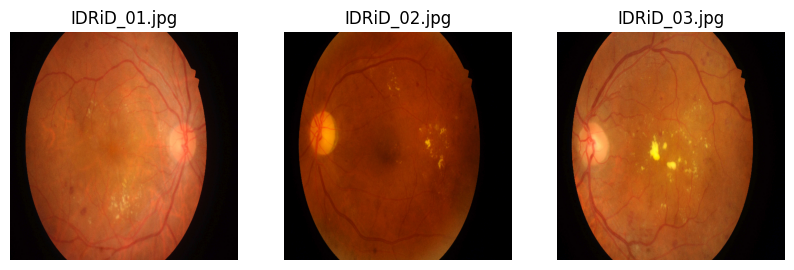

In [8]:
plt.figure(figsize=(10, 5))

for i,image in enumerate(images_train[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{images_train_listdir[i]}")
    plt.imshow(image)
    plt.axis('off')

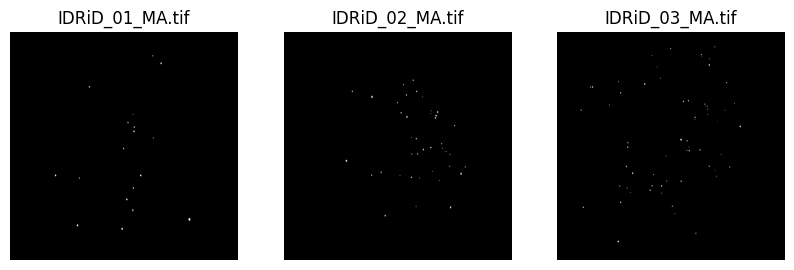

In [9]:
plt.figure(figsize=(10, 5))

for i,mask in enumerate(masks_train[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{masks_train_listdir[i]}")
    plt.imshow(mask,cmap='gray')
    plt.axis('off')

## U-net model

In [33]:
# Create an instance of the U-Net model with the specified input shape
unet_model = Unet((512,512,3))
# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=1e-4) 
    
unet_model.compile(optimizer=optimizer, 
                   loss=losses.BinaryCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

In [34]:
import warnings
warnings.filterwarnings('ignore')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

unet_history = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.2, batch_size = 2, epochs = 37,callbacks=[reduce_lr])

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 674ms/step - accuracy: 0.8412 - loss: 0.5052 - val_accuracy: 0.9957 - val_loss: 0.3551 - learning_rate: 1.0000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.9962 - loss: 0.2598 - val_accuracy: 0.9925 - val_loss: 0.3416 - learning_rate: 1.0000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9982 - loss: 0.2069 - val_accuracy: 0.9965 - val_loss: 0.3208 - learning_rate: 1.0000e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9985 - loss: 0.1815 - val_accuracy: 0.9983 - val_loss: 0.2972 - learning_rate: 1.0000e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9987 - loss: 0.1604 - val_accuracy: 0.9831 - val_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9989 - loss: 0.1441 - val_accuracy: 0.9956 - val_loss: 0.2554 - learning_rate: 1.0000e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy:

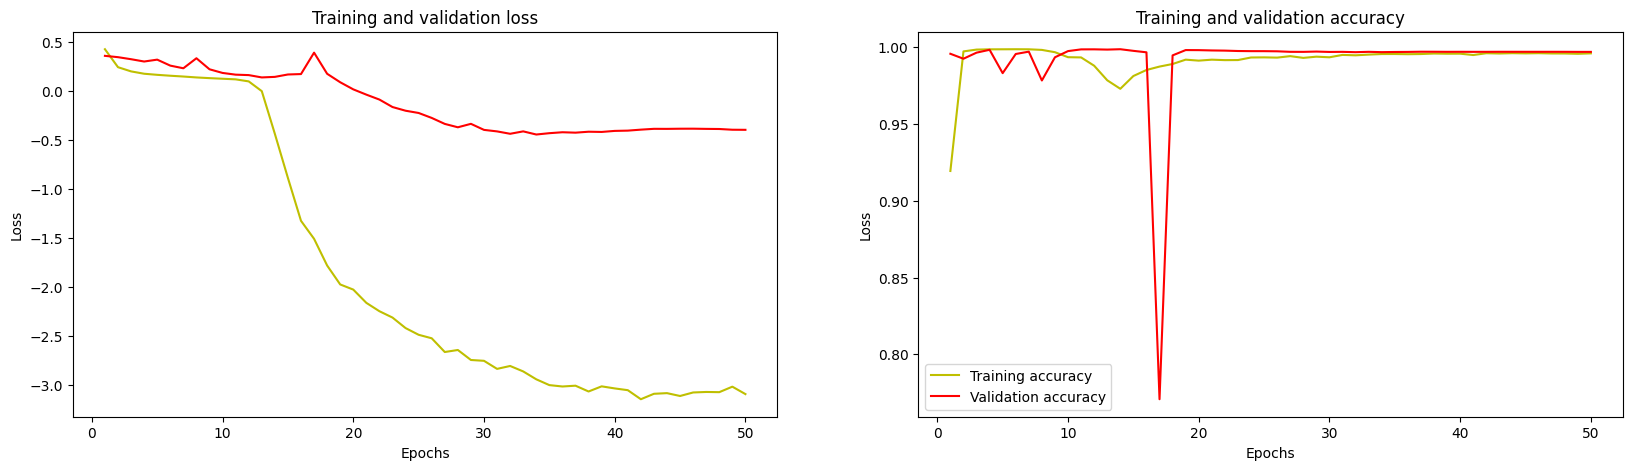

In [35]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1,2,2)
accuracy = unet_history.history['accuracy']
val_accuracy = unet_history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


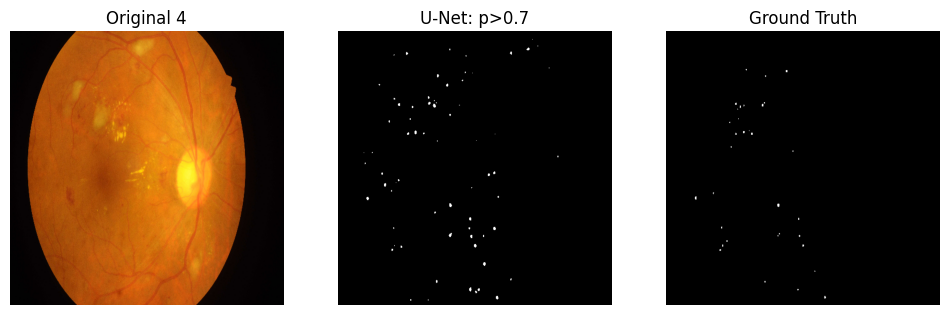

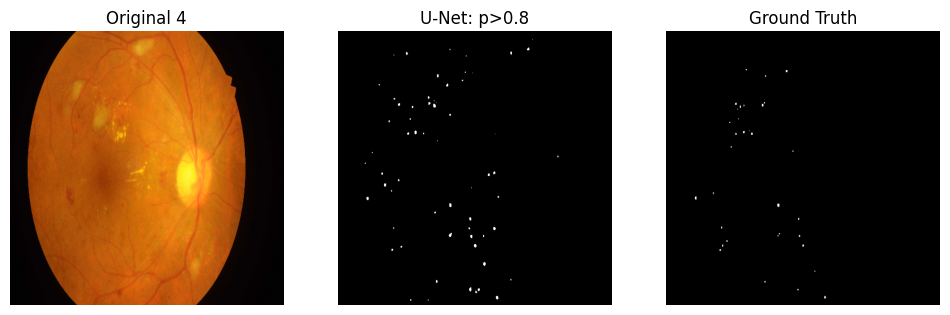

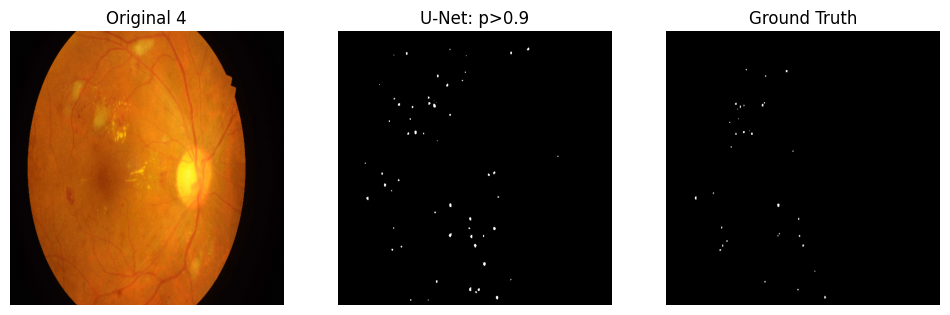

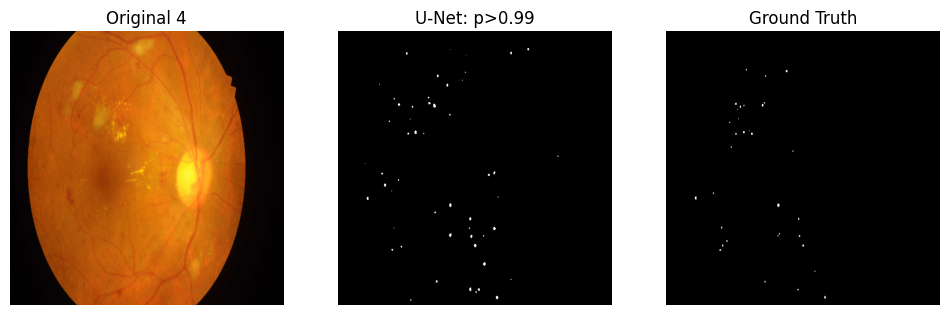

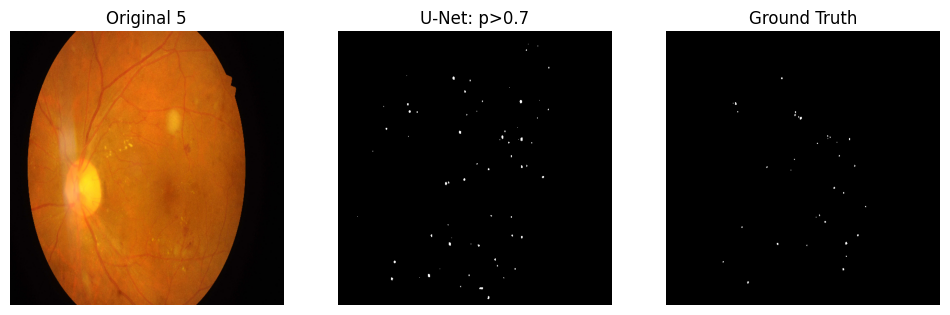

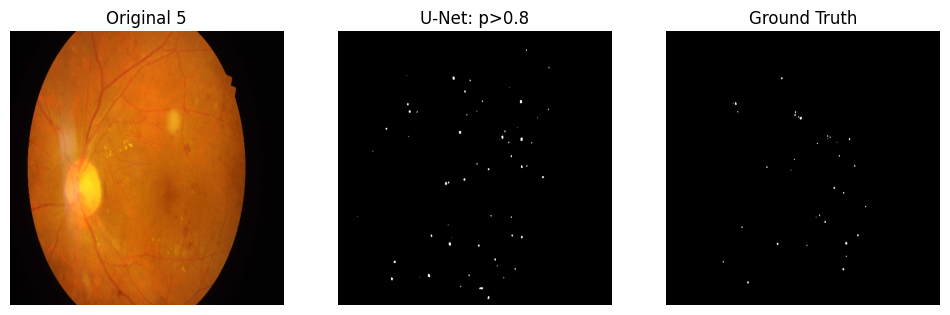

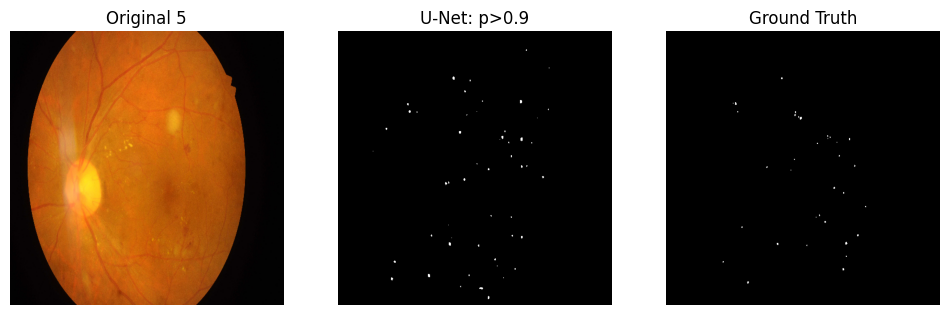

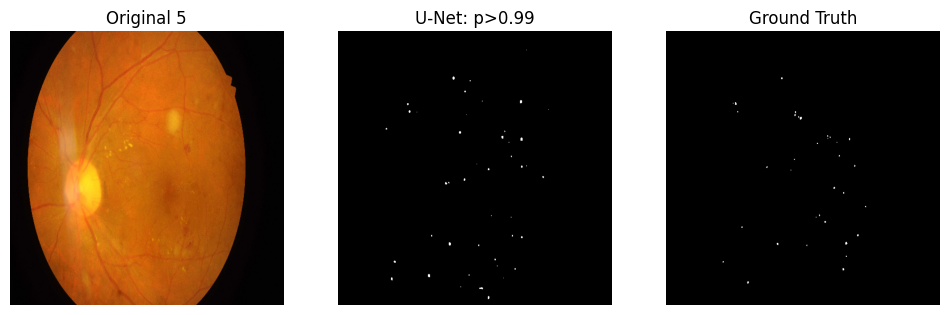

In [36]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target,cmap='gray')
    axs[2].axis('off')

    plt.show()
    
unet_predict = unet_model.predict(images_test[:20])

r1,r2,r3,r4=0.7,0.8,0.9,0.99

unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

show_test_idx = random.sample(range(len(unet_predict)), 2)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)

In [37]:
loss,accuracy = unet_model.evaluate(images_test[:20],masks_test[:20])

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9966 - loss: -0.4899
Test Loss: -0.4898701608181
Test Accuracy: 0.9965747594833374


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


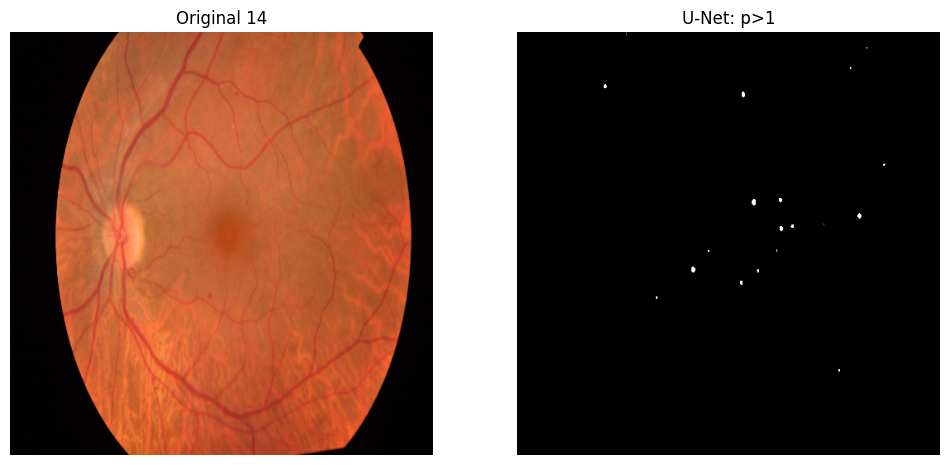

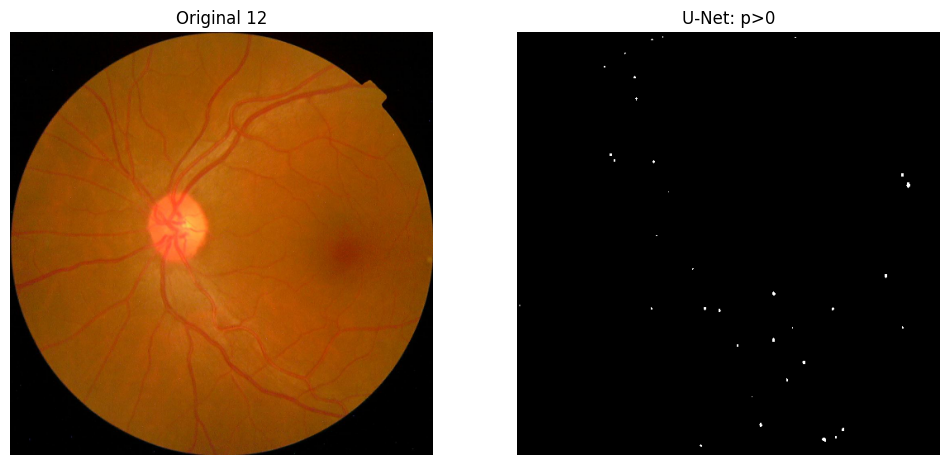

In [39]:
def show_result(idx, og, unet, p):
    
    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')

    plt.show()
    
unet_predict = unet_model.predict(x_train)

r1 = 0.99


unet_predict4 = (unet_predict > r1).astype(np.uint8)

show_test_idx = random.sample(range(len(unet_predict)), 2)
for idx in show_test_idx:
    show_result(idx, x_train[idx], unet_predict4[idx], y_train[idx])  
    

In [11]:
images_train_processed = preprocess_images(images_train)
images_test_processed = preprocess_images(images_test)

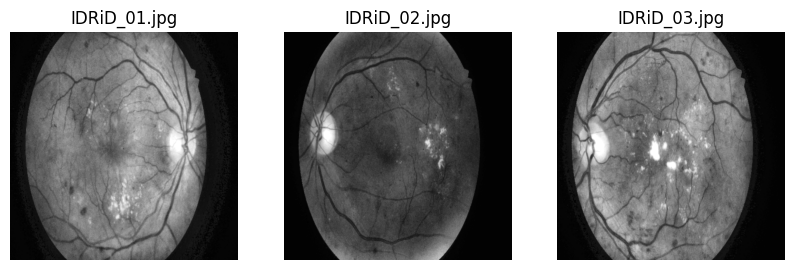

In [12]:
plt.figure(figsize=(10, 5))

for i,image in enumerate(images_train_processed[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{images_train_listdir[i]}")
    plt.imshow(image,cmap='gray')
    plt.axis('off')

In [13]:
# Create an instance of the U-Net model with the specified input shape
unet_model2 = Unet((512,512,1))
# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=1e-4) 
    
unet_model2.compile(optimizer=optimizer, 
                   loss=losses.BinaryCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

In [14]:
import warnings
warnings.filterwarnings('ignore')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

unet_history = unet_model2.fit(
    images_train_processed, masks_train, 
    validation_split = 0.1, batch_size = 2, epochs = 50)

Epoch 1/50


2024-05-15 13:25:36.085717: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.8613, expected 1.01645
2024-05-15 13:25:36.085775: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.41655, expected 1.57169
2024-05-15 13:25:36.085784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.78238, expected 1.93752
2024-05-15 13:25:36.085793: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.22846, expected 1.3836
2024-05-15 13:25:36.085801: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.28317, expected 1.43832
2024-05-15 13:25:36.085809: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.10425, expected 2.2594
2024-05-15 13:25:36.085817: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.59198, expected 1.74712
2024-05-15 13:25:36.085826: E external/local_xla/xla/servi

24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 290ms/step - accuracy: 0.9653 - loss: 0.3413 - val_accuracy: 0.9986 - val_loss: 0.6277
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9961 - loss: 0.2000 - val_accuracy: 0.9986 - val_loss: 0.5462
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9964 - loss: 0.1483 - val_accuracy: 0.9986 - val_loss: 0.4657
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.9856 - loss: 0.1116 - val_accuracy: 0.9986 - val_loss: 0.4015
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9814 - loss: 0.0490 - val_accuracy: 0.9986 - val_loss: 0.4040
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9602 - loss: -0.4561 - val_accuracy: 0.9985 - val_loss: 0.3374
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9814 - loss: -0.9525 - val_accuracy: 0.9986 - val_loss: 0.2432
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9844 - loss: -1.2928 - val_accuracy: 0.9986 -

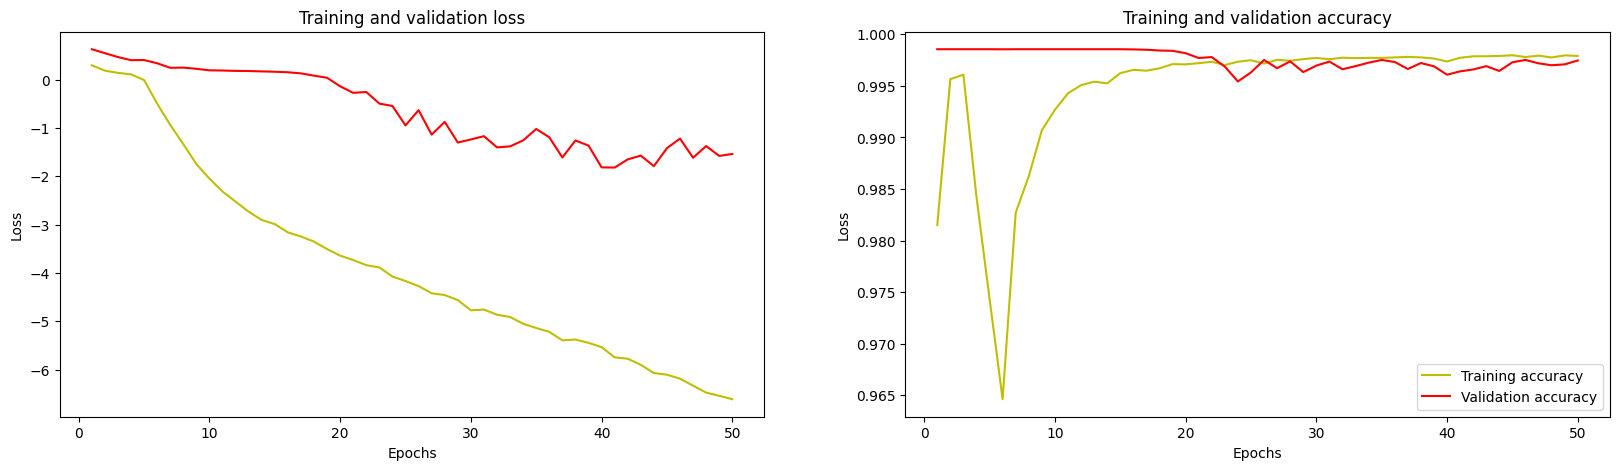

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
accuracy = unet_history.history['accuracy']
val_accuracy = unet_history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


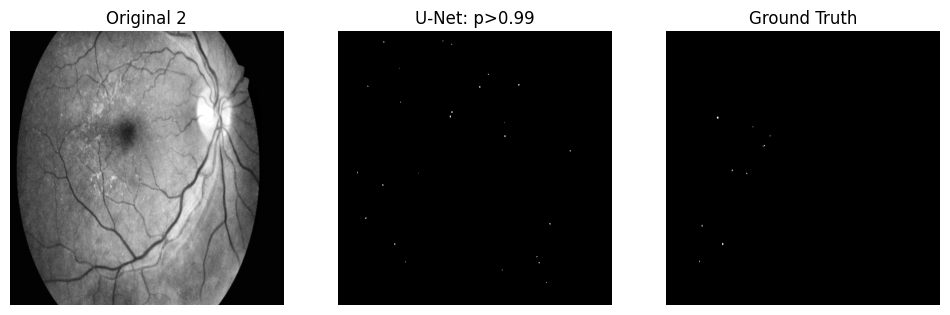

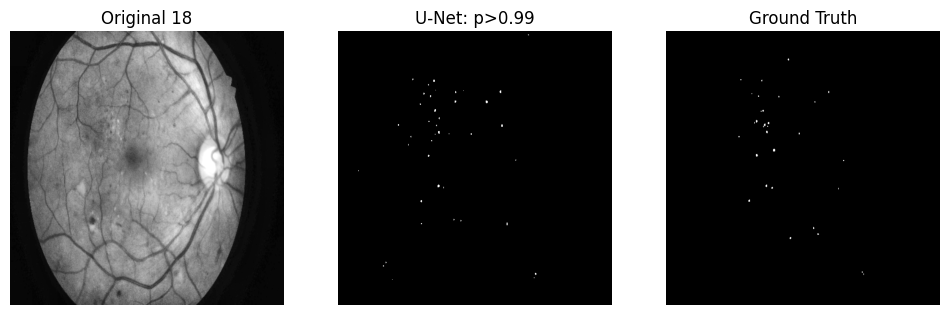

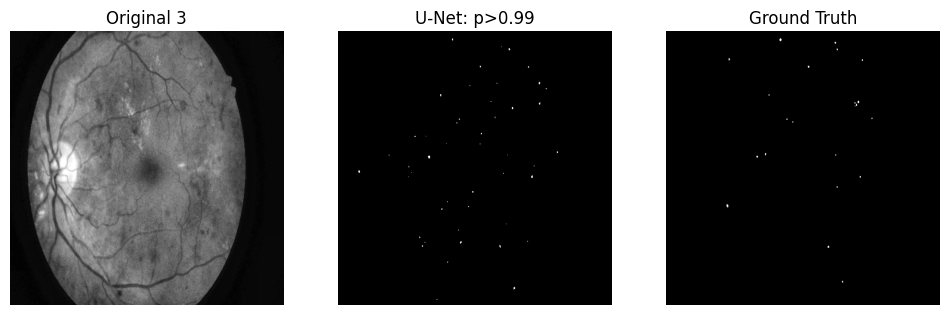

In [17]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og,cmap='gray')
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target,cmap='gray')
    axs[2].axis('off')

    plt.show()
    
unet_predict = unet_model2.predict(images_test_processed[:20])

r1 = 0.99

unet_predict1 = (unet_predict > r1).astype(np.uint8)


show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test_processed[idx], unet_predict1[idx], masks_test[idx], r1)



In [18]:
loss,accuracy = unet_model2.evaluate(images_test_processed[:20],masks_test[:20])

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9980 - loss: -0.9920
Test Loss: -0.9919894933700562
Test Accuracy: 0.9980144500732422


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


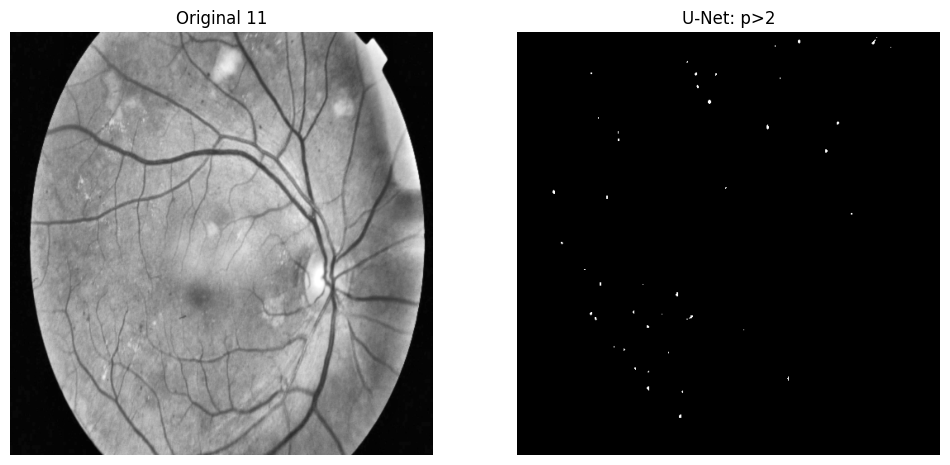

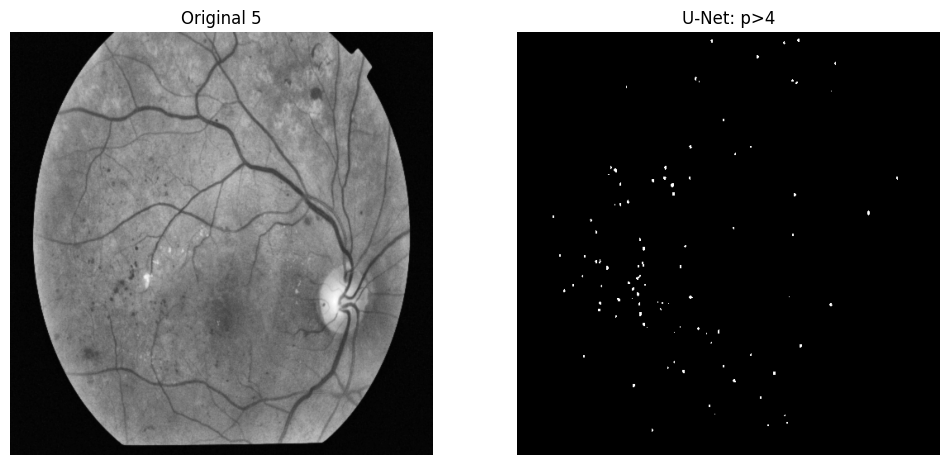

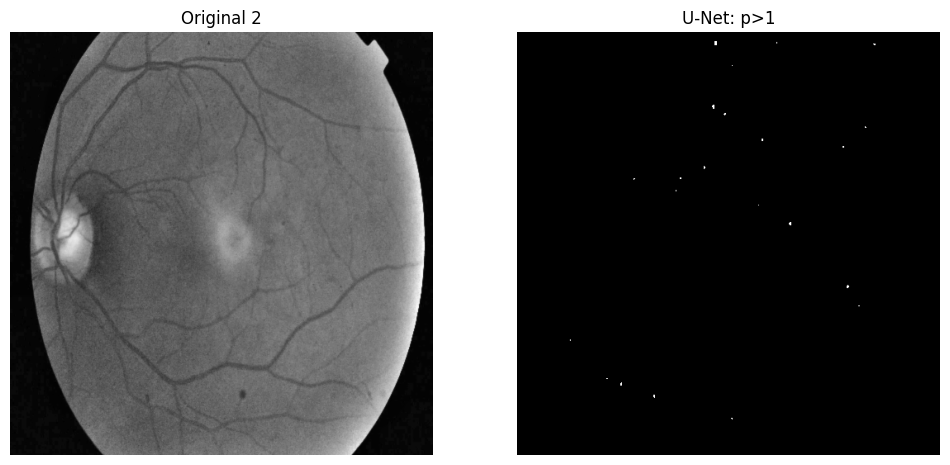

In [21]:
def show_result(idx, og, unet, p):
    
    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og,cmap='gray')
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')

    plt.show()
    
unet_predict = unet_model2.predict(preprocess_images(x_train))

r1 = 0.9

unet_predict1 = (unet_predict > r1).astype(np.uint8)


show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, preprocess_images(x_train)[idx], unet_predict1[idx], y_train[idx])
    

<h1 id='hae'>Haemorrhages Segmentation</h1>

## Importing data

In [164]:
#Training data dir
images_train_dir ='/kaggle/input/idrid-2018/IDRiD/Segmentation/Images/a. Training Set'
masks_train_dir = '/kaggle/input/idrid-2018/IDRiD/Segmentation/Mask/a. Training Set/2. Haemorrhages'
#Testing data dir
images_test_dir ='/kaggle/input/idrid-2018/IDRiD/Segmentation/Images/b. Testing Set'
masks_test_dir = '/kaggle/input/idrid-2018/IDRiD/Segmentation/Mask/b. Testing Set/2. Haemorrhages'

images_train_listdir = sorted(os.listdir(images_train_dir))
masks_train_listdir = sorted(os.listdir(masks_train_dir))

images_test_listdir = sorted(os.listdir(images_test_dir))
masks_test_listdir = sorted(os.listdir(masks_test_dir))

images_train_listdir = np.delete(images_train_listdir, 42, axis=0)

In [165]:
images_train,masks_train = read_segmentation_training_data(images_train_dir,masks_train_dir,images_train_listdir,masks_train_listdir)
images_test,masks_test = read_segmentation_training_data(images_test_dir,masks_test_dir,images_test_listdir,masks_test_listdir)

(53, 512, 512, 3) (53, 512, 512, 1)
(27, 512, 512, 3) (27, 512, 512, 1)


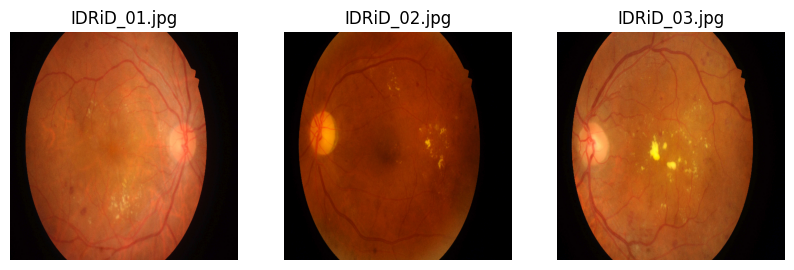

In [166]:
plt.figure(figsize=(10, 5))

for i,image in enumerate(images_train[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{images_train_listdir[i]}")
    plt.imshow(image)
    plt.axis('off')

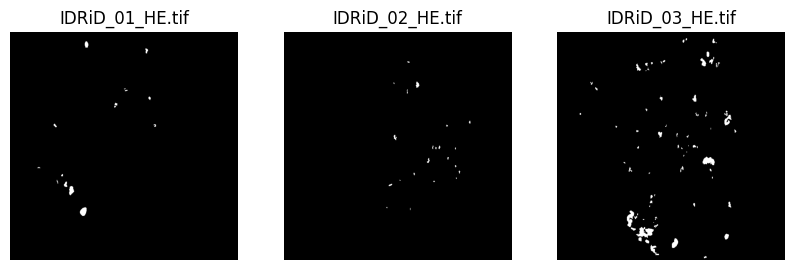

In [122]:
plt.figure(figsize=(10, 5))

for i,mask in enumerate(masks_train[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{masks_train_listdir[i]}")
    plt.imshow(mask,cmap='gray')
    plt.axis('off')

In [167]:
# Create an instance of the U-Net model with the specified input shape
unet_model = Unet((512,512,3))
# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=1e-4) 
    
unet_model.compile(optimizer=optimizer, 
                   loss=losses.BinaryCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

In [168]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, min_lr=1e-8, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

unet_history = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.1, batch_size = 2, epochs = 37)


Epoch 1/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 538ms/step - accuracy: 0.4965 - loss: 0.6204 - val_accuracy: 0.9887 - val_loss: 0.5621
Epoch 2/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.6687 - loss: -0.4317 - val_accuracy: 0.9916 - val_loss: 0.5073
Epoch 3/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.7521 - loss: -0.1789 - val_accuracy: 0.9884 - val_loss: 0.4778
Epoch 4/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.7758 - loss: -3.0521 - val_accuracy: 0.9670 - val_loss: 0.4129
Epoch 5/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8111 - loss: -1.4036 - val_accuracy: 0.9782 - val_loss: 0.4115
Epoch 6/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8384 - loss: -2.0932 - val_accuracy: 0.8536 - val_loss: 0.2948
Epoch 7/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.8589 - loss: -3.8694 - val_accuracy: 0.6239 - val_loss: 3.3033
Epoch 8/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8754 - loss: -3.3597 - val_accu

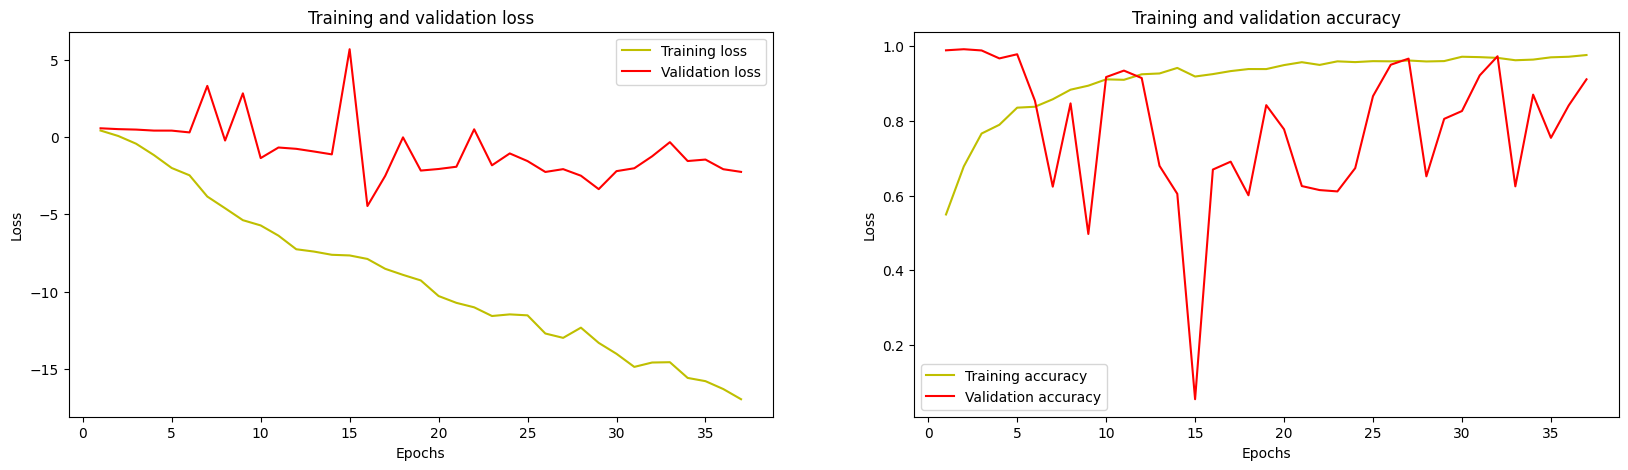

In [169]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
accuracy = unet_history.history['accuracy']
val_accuracy = unet_history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


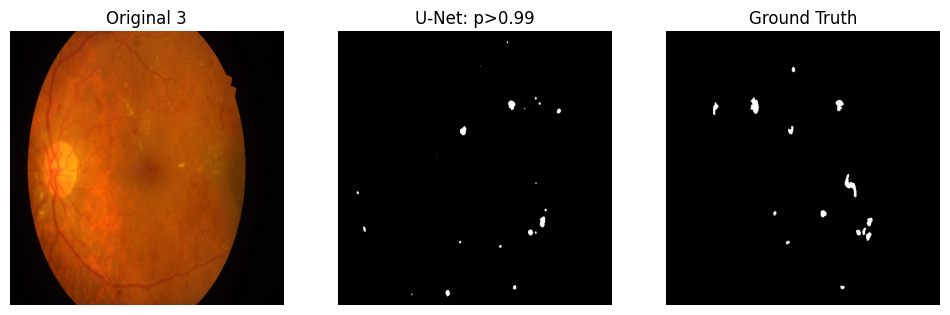

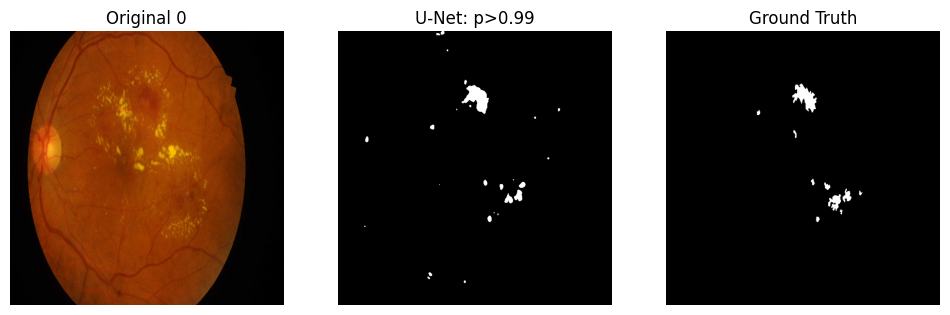

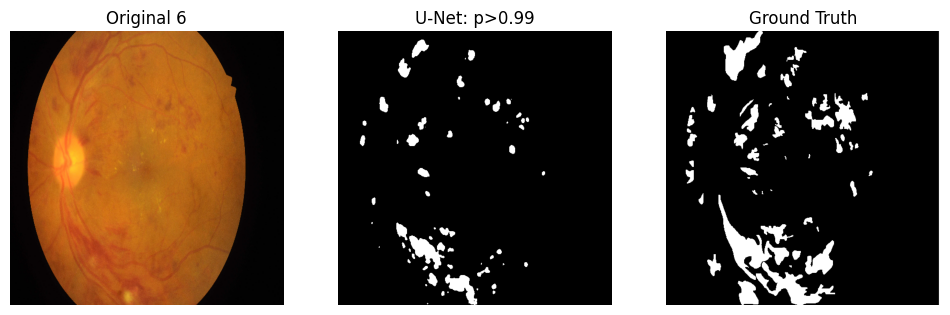

In [170]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target,cmap='gray')
    axs[2].axis('off')

    plt.show()
    
unet_predict = unet_model.predict(images_test[:20])

r1 = 0.99

unet_predict1 = (unet_predict > r1).astype(np.uint8)

show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)

In [171]:
loss,accuracy = unet_model.evaluate(images_test[:20],masks_test[:20])

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9542 - loss: -7.2424
Test Loss: -7.242393493652344
Test Accuracy: 0.9541702270507812


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


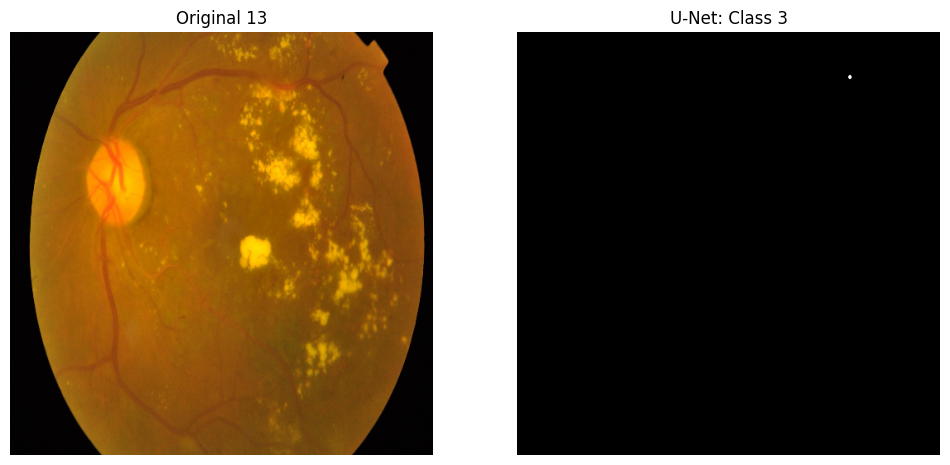

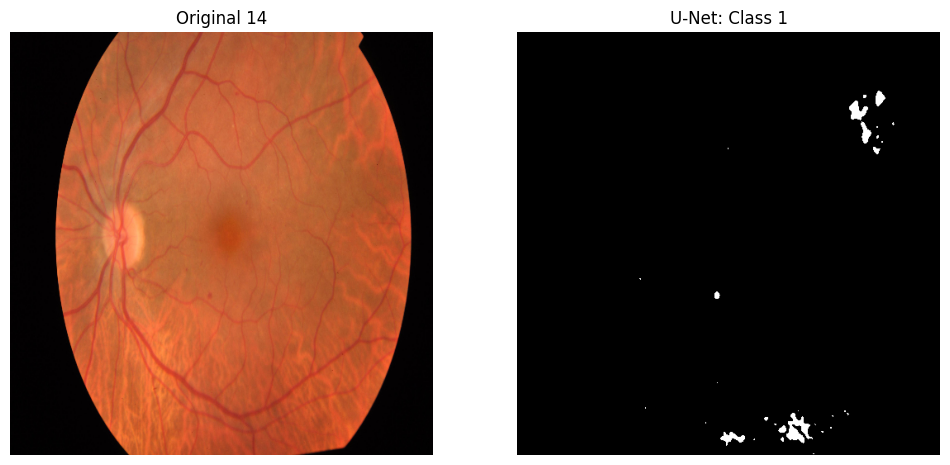

In [172]:
def show_result(idx, og, unet, p):
    
    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: Class "+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')

    plt.show()
    
unet_predict = unet_model.predict(x_train)

r1 = 0.99

unet_predict4 = (unet_predict > r1).astype(np.uint8)

show_test_idx = random.sample(range(len(unet_predict)), 2)
for idx in show_test_idx:
    show_result(idx, x_train[idx], unet_predict4[idx], y_train[idx])  
    

In [107]:
images_train_processed = preprocess_images(images_train)
images_test_processed = preprocess_images(images_test)

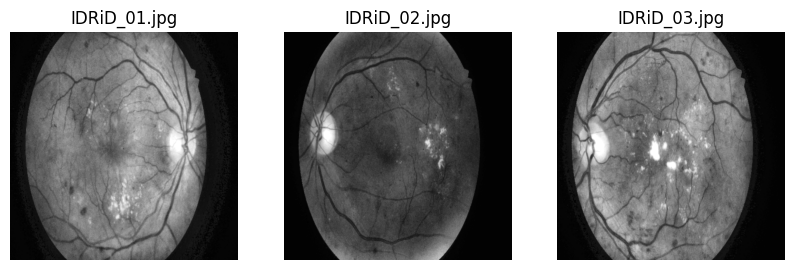

In [108]:
plt.figure(figsize=(10, 5))

for i,image in enumerate(images_train_processed[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{images_train_listdir[i]}")
    plt.imshow(image,cmap='gray')
    plt.axis('off')

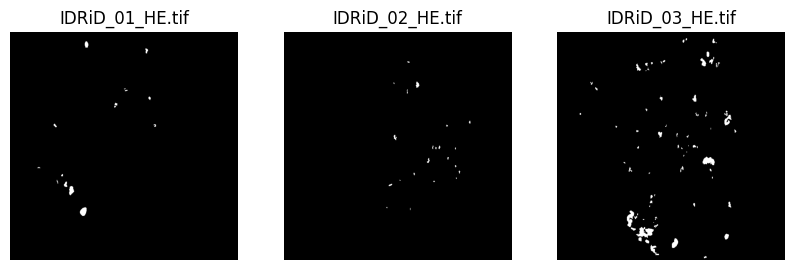

In [109]:
plt.figure(figsize=(10, 5))

for i,image in enumerate(masks_train[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{masks_train_listdir[i]}")
    plt.imshow(image,cmap='gray')
    plt.axis('off')

In [115]:
# Create an instance of the U-Net model with the specified input shape
unet_model2 = Unet((512,512,1))
# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=1e-4) 
    
unet_model2.compile(optimizer=optimizer, 
                   loss=losses.BinaryCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

In [116]:
import warnings
warnings.filterwarnings('ignore')

unet_history = unet_model2.fit(
    images_train_processed, masks_train, 
    validation_split = 0.1, batch_size = 2, epochs = 37)

Epoch 1/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 542ms/step - accuracy: 0.7804 - loss: 0.4685 - val_accuracy: 0.8210 - val_loss: 0.6656
Epoch 2/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.7907 - loss: -0.0354 - val_accuracy: 0.6697 - val_loss: 0.6668
Epoch 3/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8225 - loss: -0.8000 - val_accuracy: 0.4639 - val_loss: 0.7530
Epoch 4/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8618 - loss: -3.1381 - val_accuracy: 0.1473 - val_loss: 0.9539
Epoch 5/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.8780 - loss: -3.6701 - val_accuracy: 0.5796 - val_loss: 0.8037
Epoch 6/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9161 - loss: -4.2778 - val_accuracy: 0.6721 - val_loss: 0.6652
Epoch 7/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.9019 - loss: -6.5567 - val_accuracy: 0.6316 - val_loss: 0.7343
Epoch 8/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.9278 - loss: -6.3982 - val_accu

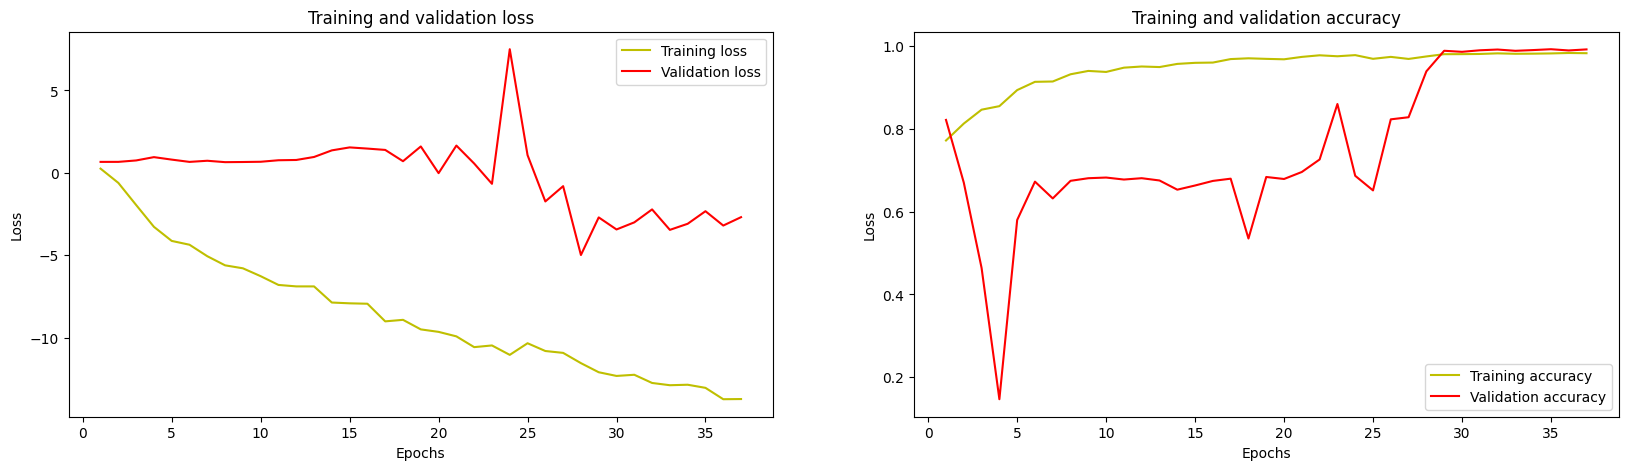

In [117]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
accuracy = unet_history.history['accuracy']
val_accuracy = unet_history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


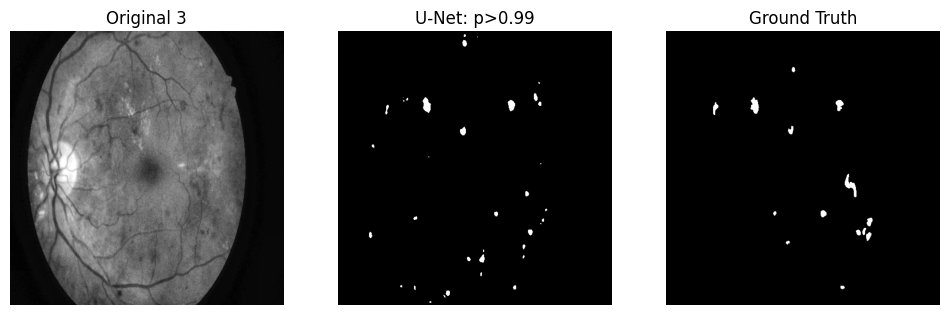

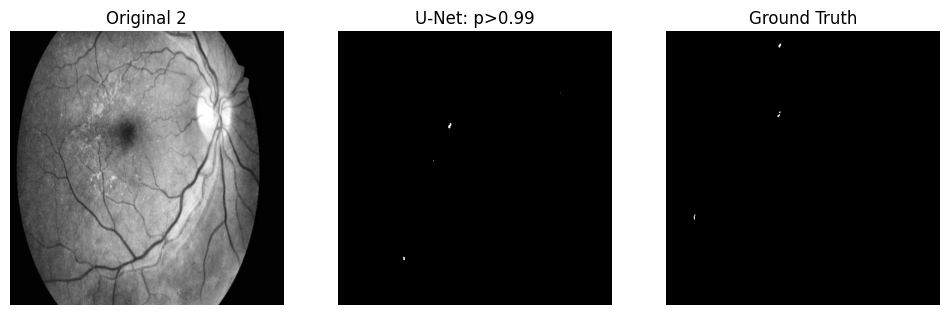

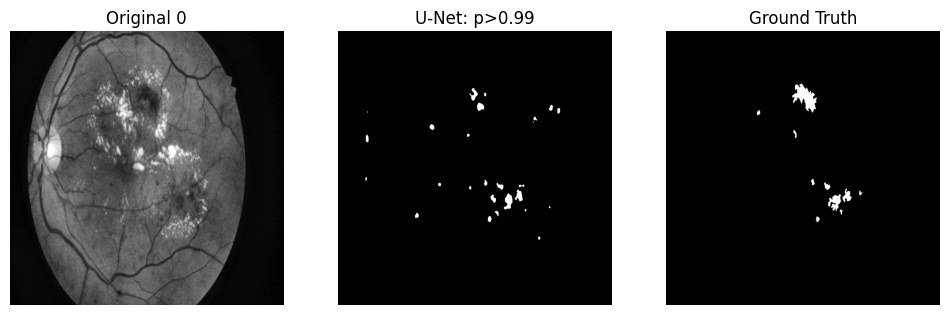

In [118]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og,cmap='gray')
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target,cmap='gray')
    axs[2].axis('off')

    plt.show()
    
unet_predict = unet_model2.predict(images_test_processed[:20])

r1 = 0.99

unet_predict1 = (unet_predict > r1).astype(np.uint8)


show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test_processed[idx], unet_predict1[idx], masks_test[idx], r1)

In [119]:
loss,accuracy = unet_model2.evaluate(images_test_processed[:20],masks_test[:20])

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9806 - loss: -5.8996
Test Loss: -5.89959192276001
Test Accuracy: 0.9805648922920227


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


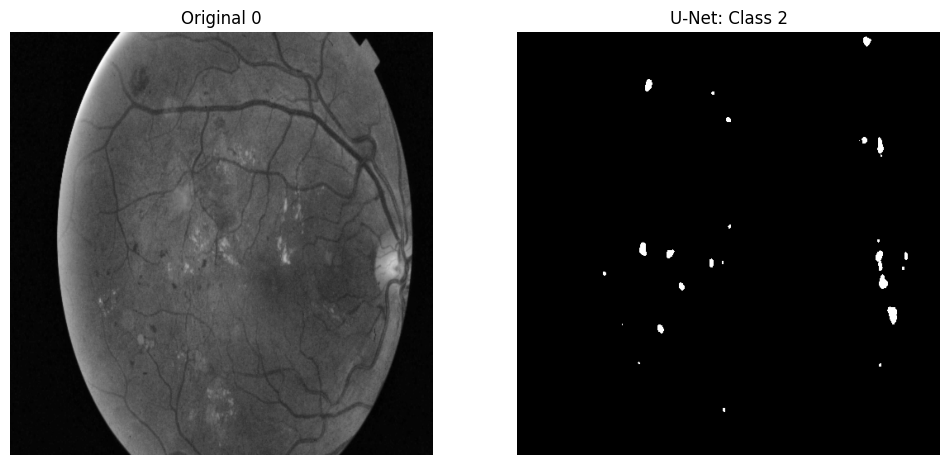

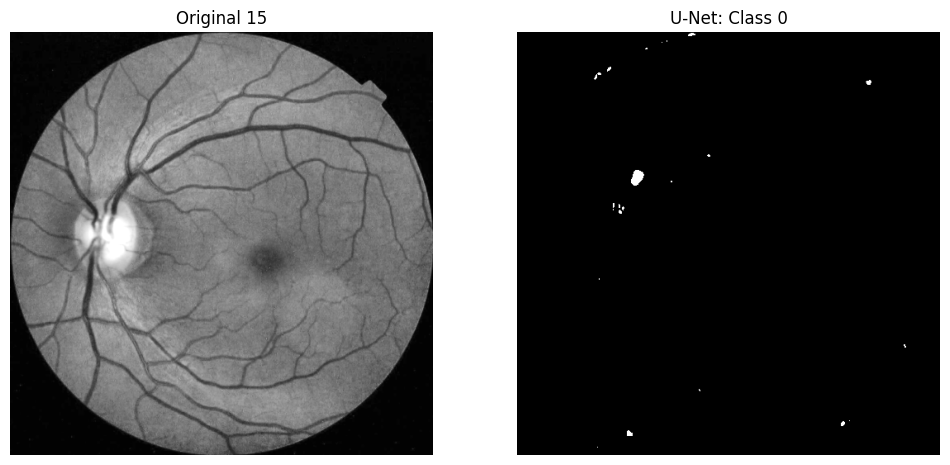

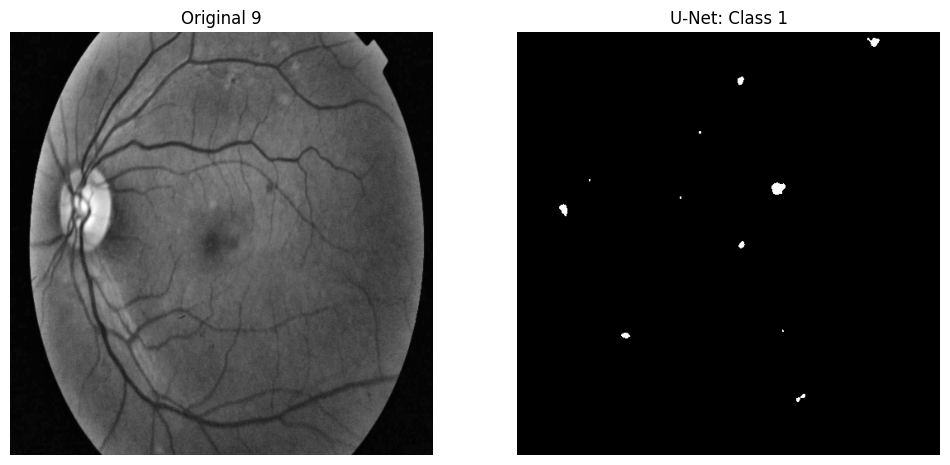

In [133]:
def show_result(idx, og, unet, p):
    
    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og,cmap='gray')
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: Class "+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')

    plt.show()
    
unet_predict = unet_model2.predict(preprocess_images(x_train))

r1 = 0.9

unet_predict1 = (unet_predict > r1).astype(np.uint8)

show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, preprocess_images(x_train)[idx], unet_predict1[idx], y_train[idx])
    

In [134]:
unet_model.save('Haemorrhages_u-net.h5')
unet_model2.save('Haemorrhages_u-net_preprocessed.h5')

<h1 id='hes'>Hard Exudates Segmentation</h1>

## Importing data

In [135]:
#Training data dir
images_train_dir ='/kaggle/input/idrid-2018/IDRiD/Segmentation/Images/a. Training Set'
masks_train_dir = '/kaggle/input/idrid-2018/IDRiD/Segmentation/Mask/a. Training Set/3. Hard Exudates'
#Testing data dir
images_test_dir ='/kaggle/input/idrid-2018/IDRiD/Segmentation/Images/b. Testing Set'
masks_test_dir = '/kaggle/input/idrid-2018/IDRiD/Segmentation/Mask/b. Testing Set/3. Hard Exudates'

images_train_listdir = sorted(os.listdir(images_train_dir))
masks_train_listdir = sorted(os.listdir(masks_train_dir))

images_test_listdir = sorted(os.listdir(images_test_dir))
masks_test_listdir = sorted(os.listdir(masks_test_dir))

In [136]:
images_train,masks_train = read_segmentation_training_data(images_train_dir,masks_train_dir,images_train_listdir,masks_train_listdir)
images_test,masks_test = read_segmentation_training_data(images_test_dir,masks_test_dir,images_test_listdir,masks_test_listdir)

(54, 512, 512, 3) (54, 512, 512, 1)
(27, 512, 512, 3) (27, 512, 512, 1)


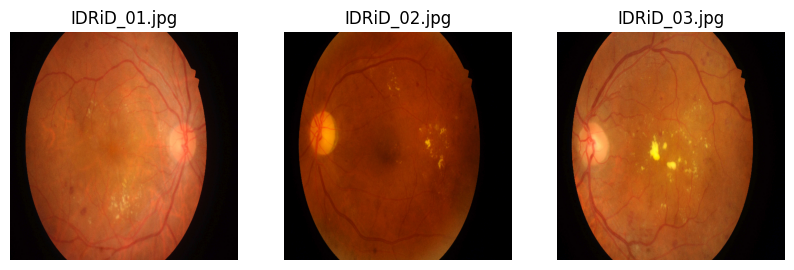

In [137]:
plt.figure(figsize=(10, 5))

for i,image in enumerate(images_train[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{images_train_listdir[i]}")
    plt.imshow(image)
    plt.axis('off')

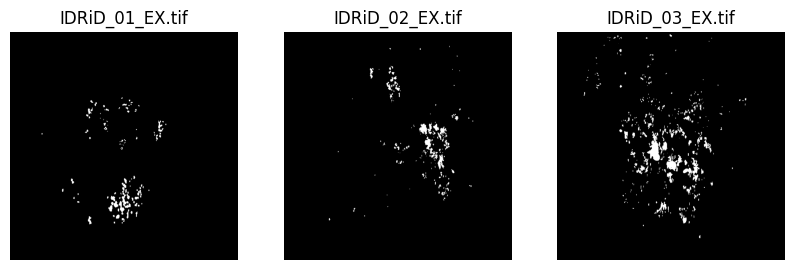

In [138]:
plt.figure(figsize=(10, 5))

for i,mask in enumerate(masks_train[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{masks_train_listdir[i]}")
    plt.imshow(mask,cmap='gray')
    plt.axis('off')

In [139]:
# Create an instance of the U-Net model with the specified input shape
unet_model = Unet((512,512,3))
# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=1e-4) 
    
unet_model.compile(optimizer=optimizer, 
                   loss=losses.BinaryCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

In [140]:
unet_history = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.1, batch_size = 2, epochs = 37)


Epoch 1/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step - accuracy: 0.7200 - loss: -0.0755 - val_accuracy: 0.7178 - val_loss: 0.5370
Epoch 2/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8985 - loss: -2.3896 - val_accuracy: 0.6205 - val_loss: 0.4554
Epoch 3/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.9133 - loss: -2.9720 - val_accuracy: 0.8567 - val_loss: 0.2673
Epoch 4/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.9154 - loss: -5.5937 - val_accuracy: 0.9807 - val_loss: 0.2158
Epoch 5/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9347 - loss: -6.6494 - val_accuracy: 0.9596 - val_loss: -1.0023
Epoch 6/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9426 - loss: -6.4199 - val_accuracy: 0.9808 - val_loss: -0.3567
Epoch 7/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9451 - loss: -6.8306 - val_accuracy: 0.9877 - val_loss: -0.8197
Epoch 8/37
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9552 - loss: -5.3588 - val_

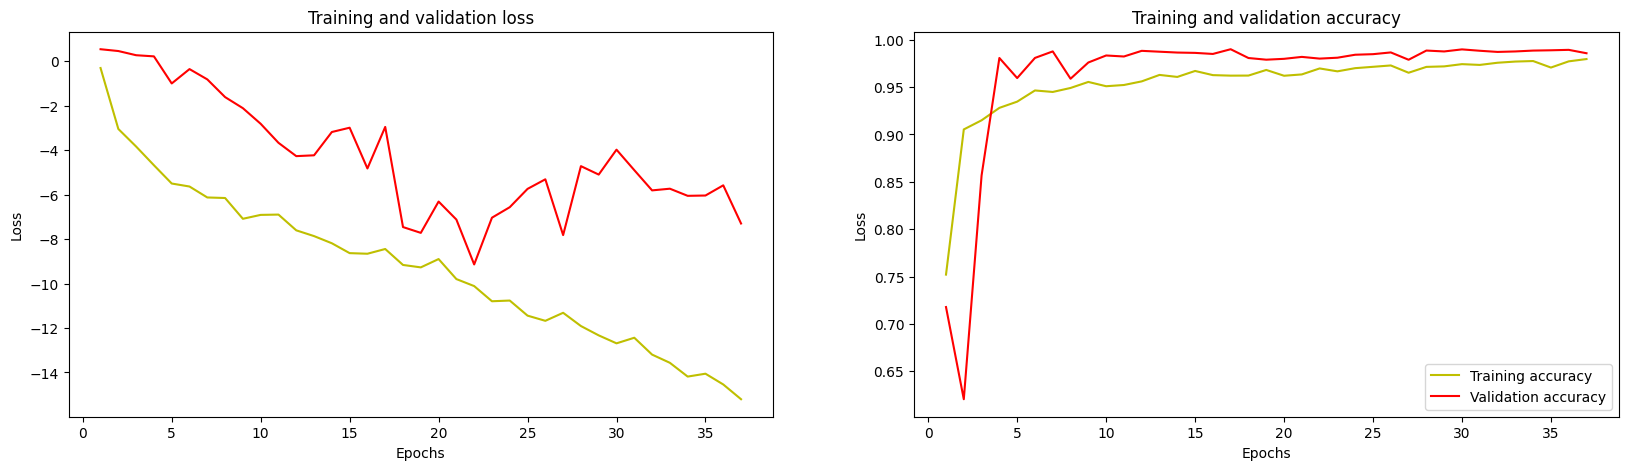

In [142]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1,2,2)
accuracy = unet_history.history['accuracy']
val_accuracy = unet_history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


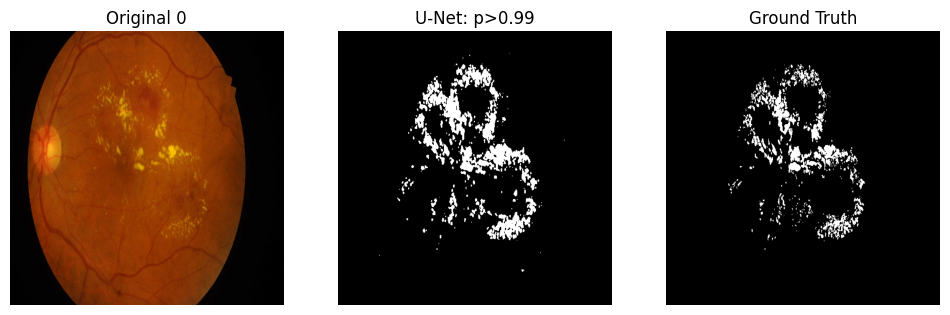

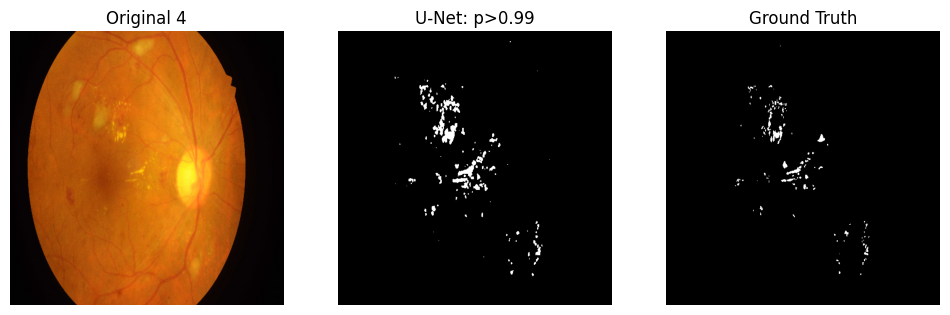

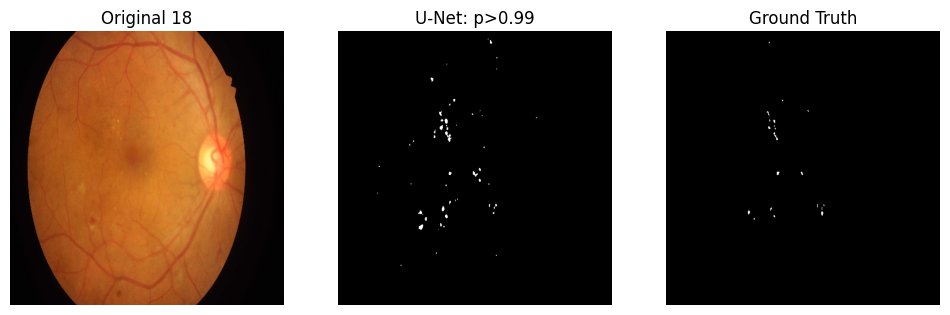

In [143]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target,cmap='gray')
    axs[2].axis('off')

    plt.show()
    
unet_predict = unet_model.predict(images_test[:20])

r1 = 0.99

unet_predict1 = (unet_predict > r1).astype(np.uint8)

show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)

In [144]:
loss,accuracy = unet_model.evaluate(images_test[:20],masks_test[:20])

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9766 - loss: -12.9909
Test Loss: -12.990934371948242
Test Accuracy: 0.9766172170639038


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


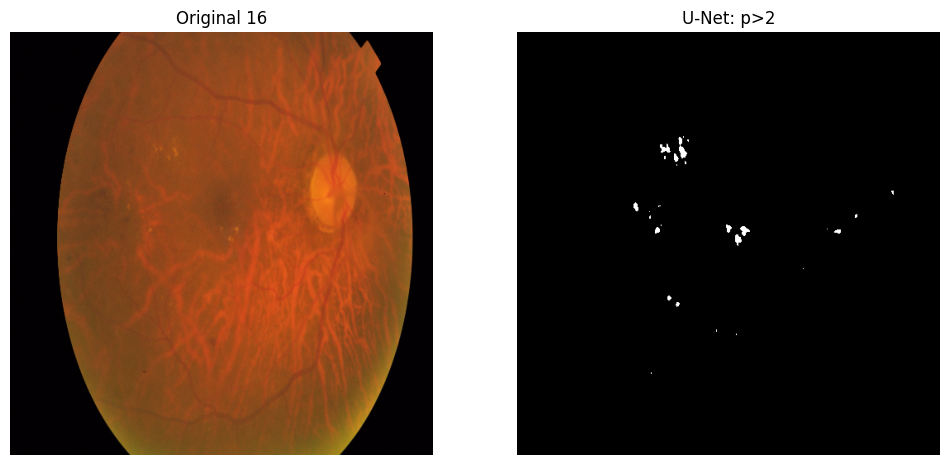

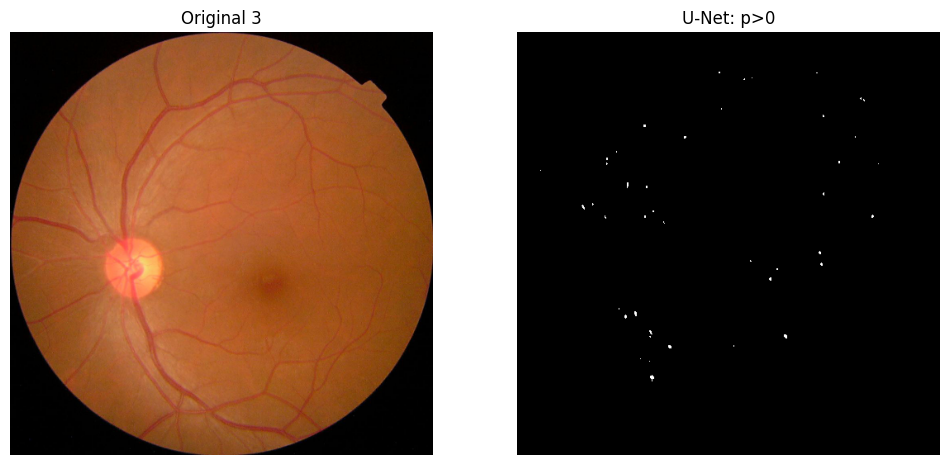

In [146]:
def show_result(idx, og, unet, p):
    
    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')

    plt.show()
    
unet_predict = unet_model.predict(x_train)

r1 = 0.99


unet_predict4 = (unet_predict > r1).astype(np.uint8)

show_test_idx = random.sample(range(len(unet_predict)), 2)
for idx in show_test_idx:
    show_result(idx, x_train[idx], unet_predict4[idx], y_train[idx])  
    

In [147]:
images_train_processed = preprocess_images(images_train)
images_test_processed = preprocess_images(images_test)

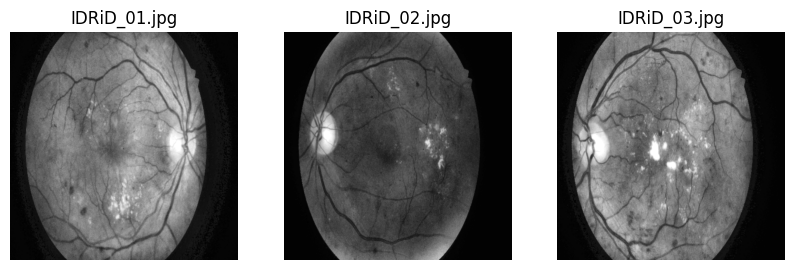

In [148]:
plt.figure(figsize=(10, 5))

for i,image in enumerate(images_train_processed[:3]):
    plt.subplot(1, 3, i+1)
    plt.title(f"{images_train_listdir[i]}")
    plt.imshow(image,cmap='gray')
    plt.axis('off')

In [149]:
# Create an instance of the U-Net model with the specified input shape
unet_model2 = Unet((512,512,1))
# Compile the model with Adam optimizer and binary crossentropy loss
optimizer = Adam(learning_rate=1e-4) 
    
unet_model2.compile(optimizer=optimizer, 
                   loss=losses.BinaryCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

In [150]:
import warnings
warnings.filterwarnings('ignore')

unet_history = unet_model2.fit(
    images_train_processed, masks_train, 
    validation_split = 0.1, batch_size = 2, epochs = 50)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 282ms/step - accuracy: 0.7883 - loss: 0.0205 - val_accuracy: 0.9943 - val_loss: 0.6453
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9034 - loss: -3.5158 - val_accuracy: 0.9943 - val_loss: 0.5559
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9298 - loss: -4.2991 - val_accuracy: 0.9943 - val_loss: 0.4870
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9376 - loss: -5.1049 - val_accuracy: 0.9943 - val_loss: 0.4507
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9436 - loss: -5.6060 - val_accuracy: 0.9943 - val_loss: 0.4390
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9396 - loss: -6.6109 - val_accuracy: 0.9943 - val_loss: 0.4380
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9579 - loss: -5.6621 - val_accuracy: 0.9943 - val_loss: 0.4445
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.9401 - loss: -5.8516 - val_accu

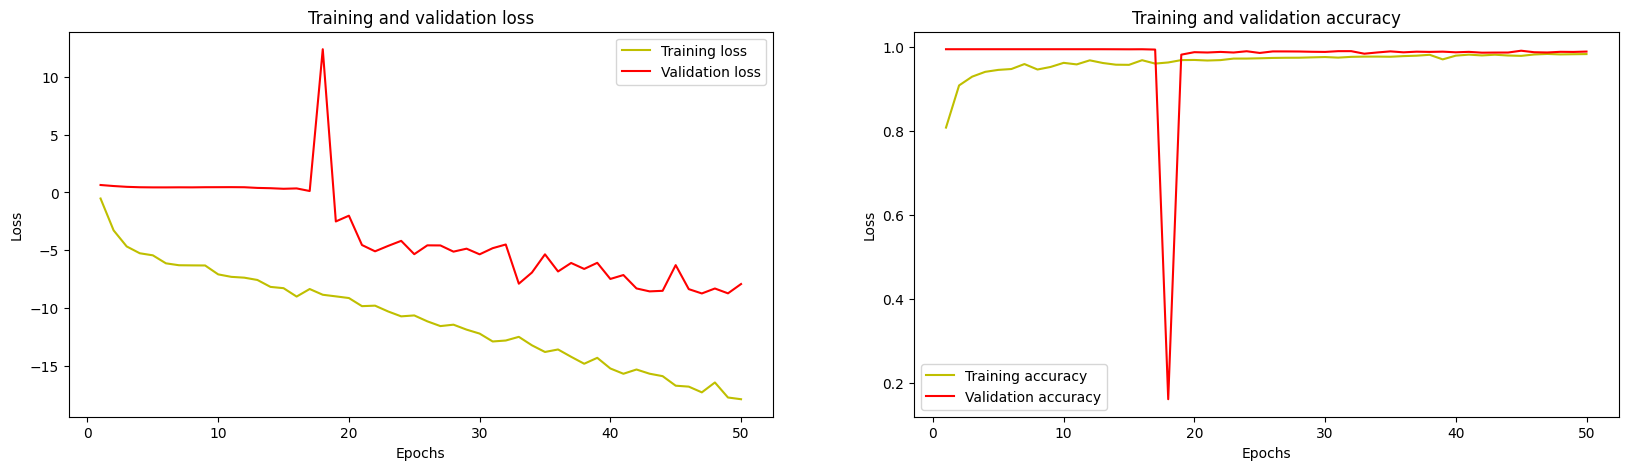

In [151]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
loss = unet_history.history['loss']
val_loss = unet_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
accuracy = unet_history.history['accuracy']
val_accuracy = unet_history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


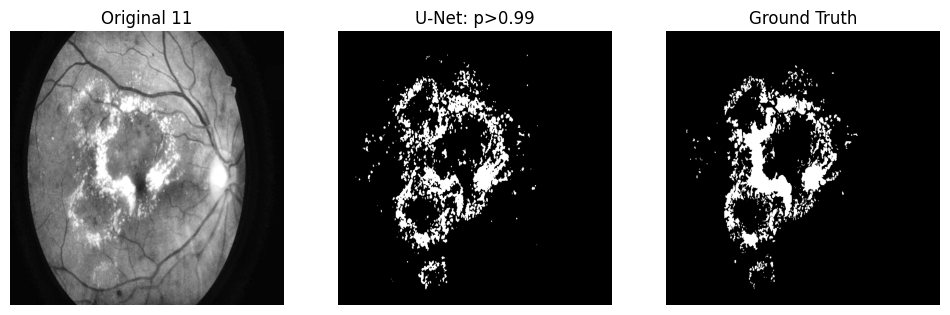

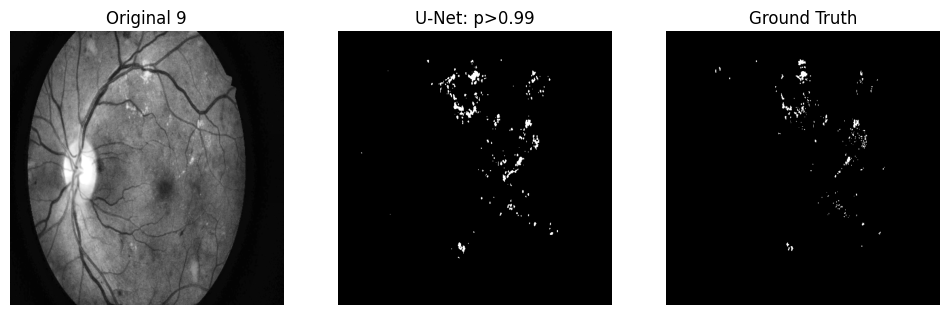

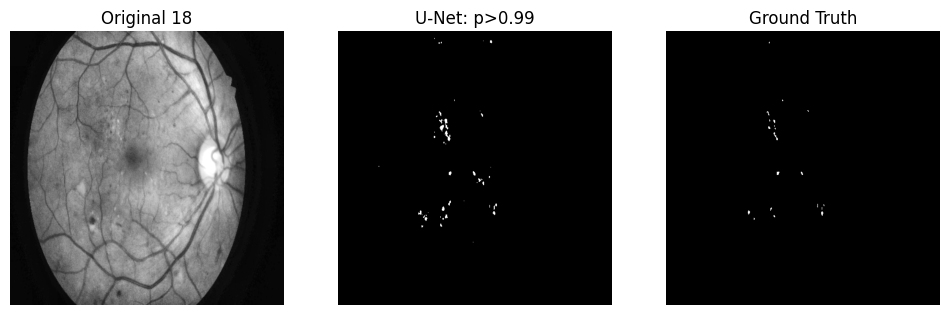

In [152]:
def show_result(idx, og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og,cmap='gray')
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target,cmap='gray')
    axs[2].axis('off')

    plt.show()
    
unet_predict = unet_model2.predict(images_test_processed[:20])

r1 = 0.99

unet_predict1 = (unet_predict > r1).astype(np.uint8)


show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test_processed[idx], unet_predict1[idx], masks_test[idx], r1)

In [153]:
loss,accuracy = unet_model2.evaluate(images_test_processed[:20],masks_test[:20])

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9799 - loss: -16.7401
Test Loss: -16.740135192871094
Test Accuracy: 0.9798921346664429


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


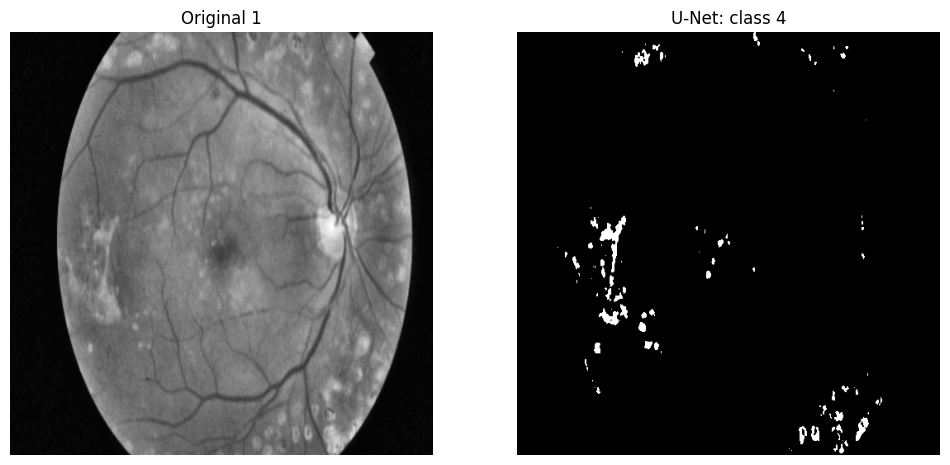

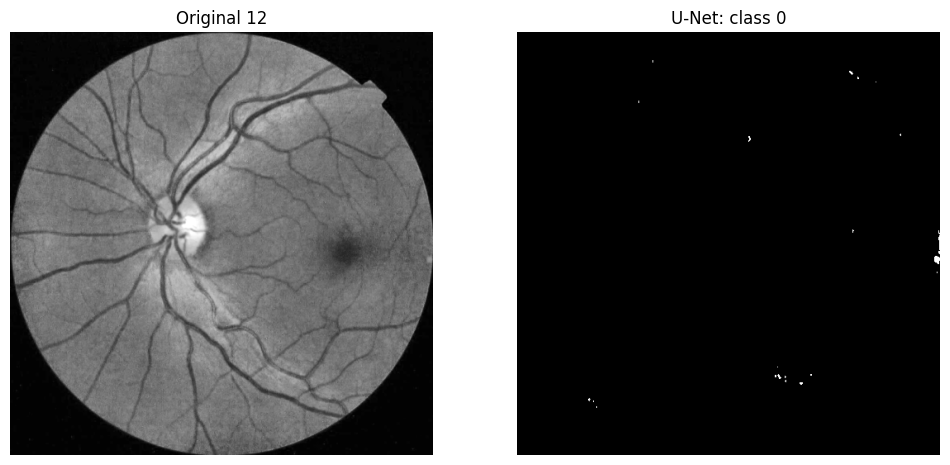

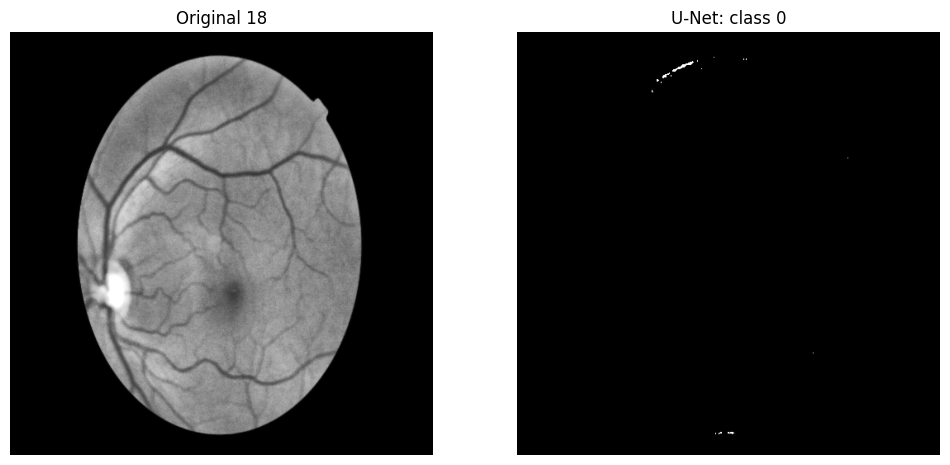

In [156]:
def show_result(idx, og, unet, p):
    
    fig, axs = plt.subplots(1, 2, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og,cmap='gray')
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: class "+str(p))
    axs[1].imshow(unet,cmap='gray')
    axs[1].axis('off')

    plt.show()
    
unet_predict = unet_model2.predict(preprocess_images(x_train))

r1 = 0.9

unet_predict1 = (unet_predict > r1).astype(np.uint8)


show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, preprocess_images(x_train)[idx], unet_predict1[idx], y_train[idx])
    

In [159]:
unet_model.save('HardExudates_u-net.h5')
unet_model2.save('HardExudates_u-net_preprocessed.h5')